In [45]:
import os
import subprocess
import sys
# import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3
from IPython.display import IFrame

from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np
import seaborn as sns

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj

/usr/local/grass85


In [314]:
gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
site = 'SJER'
mapset = 'sensitivity_1'
gj.init(gisdb, site, mapset)

In [ ]:
!g.list type=rast pattern=*error*

In [ ]:
gs.run_command('g.region', raster='elevation_1', res=1, flags='ap')
gs.run_command('r.univar', map='elevation_1', flags='e')

errorMap = gj.Map()
errorMap.d_rast(map='error_30_4_0.09')
errorMap.d_legend(raster='error_30_4_0.09', at=(80, 90, 2, 6), flags='b')
errorMap.show()

In [102]:
analysis_metadata = os.path.join("../output", site, mapset, 'sensitivity_analysis_1.csv')

df_metadata = pd.read_csv(analysis_metadata)
df_metadata['area_m2'] = df_metadata['cells'] * df_metadata['resolution'] ** 2
df_metadata['area_km2'] = df_metadata['area_m2'] / 1e6
df_metadata.head(100)

,site_name,resolution,scalar,cells,particles,run_n,run_time,area_m2,area_km2
0,SJER,1,0.25,293592,73398.0,0,37.116496,293592,0.293592
1,SJER,1,0.25,293592,73398.0,1,38.866221,293592,0.293592
2,SJER,1,0.25,293592,73398.0,2,49.714063,293592,0.293592
3,SJER,1,0.25,293592,73398.0,3,45.413891,293592,0.293592
4,SJER,1,0.25,293592,73398.0,4,42.760461,293592,0.293592
...,...,...,...,...,...,...,...,...,...
95,SJER,3,4.00,32621,130484.0,5,5.753727,293589,0.293589
96,SJER,3,4.00,32621,130484.0,6,5.600056,293589,0.293589
97,SJER,3,4.00,32621,130484.0,7,5.831520,293589,0.293589
98,SJER,3,4.00,32621,130484.0,8,5.823895,293589,0.293589


In [108]:
df_grouped = (
    df_metadata
        .groupby(by=['resolution', 'scalar'])
        .agg({
            'run_time': 'mean',
            'particles': 'mean',
            'cells': 'max',
            'area_km2': 'max',
        })
        .reset_index()
)

df_grouped.head(20)

,resolution,scalar,run_time,particles,cells,area_km2
0,1,0.25,42.592428,73398.00,293592,0.293592
1,1,0.50,38.214426,146796.00,293592,0.293592
2,1,1.00,75.493386,293592.00,293592,0.293592
3,1,2.00,104.879357,587184.00,293592,0.293592
4,1,4.00,166.640662,1174368.00,293592,0.293592
5,3,0.25,1.437649,8155.25,32621,0.293589
6,3,0.50,1.435448,16310.50,32621,0.293589
7,3,1.00,2.513484,32621.00,32621,0.293589
8,3,2.00,3.587835,65242.00,32621,0.293589
9,3,4.00,5.675939,130484.00,32621,0.293589


/tmp/ipykernel_252118/980624694.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_252118/980624694.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Particle Factor", fontsize=18)


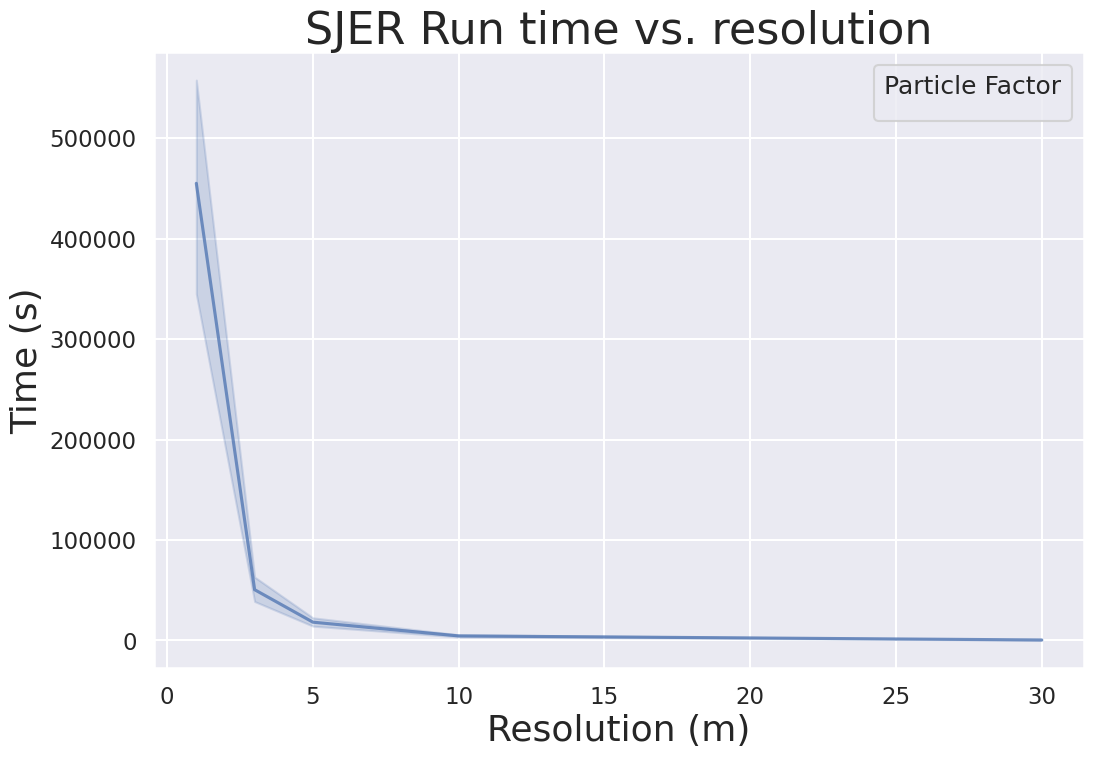

In [357]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=df_metadata,
    # x="resolution",
    # y="run_time",
    # hue="scalar",
    # x="cells",
    # x="resolution",
    # y="run_time",
    # hue="resolution",
    x="resolution",
    y="particles",
    palette="crest_r",
    alpha=0.75,
    errorbar=('ci', 95)
)
plt.xlabel("Resolution (m)", fontsize=26)
plt.ylabel("Time (s)", fontsize=26)
plt.title("SJER Run time vs. resolution", fontsize=32)
plt.legend(title="Particle Factor", fontsize=18)
plt.savefig(f"../output/{site}/{mapset}/{site}_run_time_res_line_plot.png")
plt.show()

/tmp/ipykernel_252118/1660174662.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/tmp/ipykernel_252118/1660174662.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


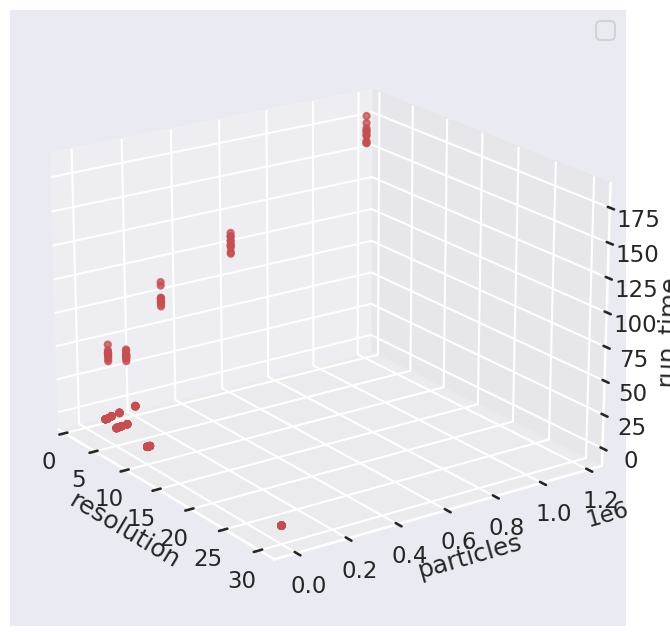

In [374]:

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.scatter(
    df_metadata['resolution'],
    df_metadata['particles'],
    df_metadata['run_time'],
    c='r',
    alpha=0.75,
    marker='o',
    cmap='viridis'
)

ax.legend()
ax.set_xlabel('resolution')
ax.set_ylabel('particles')
ax.set_zlabel('run_time')
ax.view_init(elev=20., azim=-35, roll=0)
plt.show()

<Axes: xlabel='resolution', ylabel='run_time'>

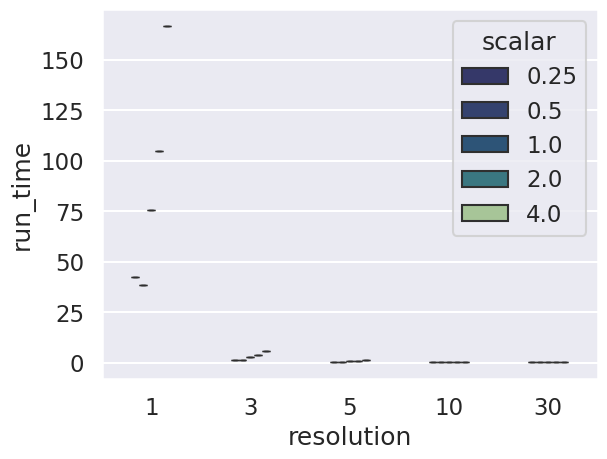

In [177]:
sns.boxplot(
    df_grouped,
    x="resolution",
    y="run_time",
    hue="scalar",
    palette="crest_r",
    width=.4, 
    # palette="vlag"
)

<Axes: xlabel='resolution', ylabel='scalar'>

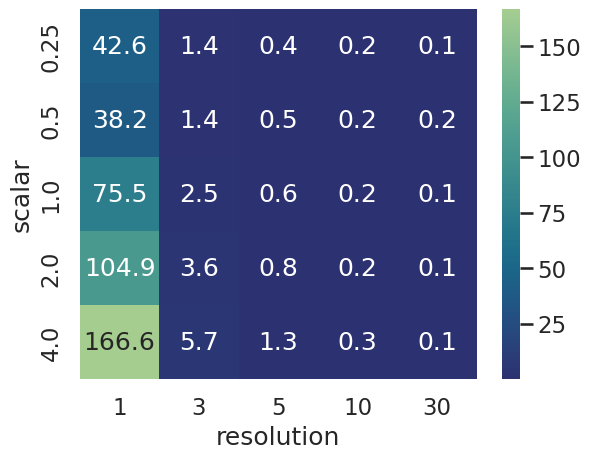

In [179]:
df_metadata_pivot = df_metadata.pivot_table(index="scalar", columns="resolution", values="run_time")
sns.heatmap(
    df_metadata_pivot,
    annot=True,
    fmt=".1f",
    cmap="crest_r"
)

In [ ]:
!g.remove -f type=raster pattern="*_01m*"

In [297]:
def get_simwe_time_steps(search_pattern):
    """Returns a list of time steps from the SIMWE output as """
    timestep_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",
    ).strip()
    # print(timestep_list)
    time_steps = [str(t.split(".")[-1]) for t in timestep_list.split(",")]
    # print(time_steps)
    def filter_subset(x):
        # print(x)
        if "_01m" not in x:
            return x

    time_steps_filtered = filter(lambda x: filter_subset(x), time_steps)
    return sorted(list(set(time_steps_filtered)))

res = "30"
scalar_str = "025"
method = "average"
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
test_list =  get_simwe_time_steps(f"depth_{res}_{scalar_str}_*.*")
print(test_list)

['05', '09', '14', '18', '23']


In [ ]:
for step in test_list:
    # print(step)
    # Get list of maps for the current time step
    search_pattern = f"depth_{res}_{scalar_str}_*.{step}"
    depth_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",  # noqa: E501
    ).strip()

    strds_name = f"depth_{res}_{scalar_str}_s_{method}"

    if depth_list:
        print(f"Time step {step} has {len(depth_list.split(','))} maps")
        print(depth_list)

        depth_simwe_methods = "average,median,minimum,maximum"
        depth_series_outputs = ",".join(
            [
                f"depth_{res}_{scalar_str}_s_{step}_{m}"
                for m in depth_simwe_methods.split(",")
            ]
        )
        last_depth_time_step = depth_list.split(',')[-1]
        print(f"last_depth_time_step: {last_depth_time_step}")
        print(depth_series_outputs)

      

In [217]:
# !t.list type=strds where="mapset = 'sensitivity_1'"
# depth_30_025_s_05_01m
res = "30"
scalar_str = "4" #"025"  0.5, 1, 2, 4
method = "median"
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
# Average SWIME Simulation STRDS from 10 SIMWE simulations
depth_average = f"depth_{res}_{scalar_str}_s_median"
disch_average = f"discharge_{res}_{scalar_str}_s_average"

# Single SWIME Simulation STRDS
depth_single_run = f"depth_sum_{res}_{scalar_str}"
disch_single_run = f"depth_sum_{res}_{scalar_str}"

def filter_subset(x):
    if "_01m" in x:
        return x
    
for method in methods.split(","):
    depth_average = f"depth_{res}_{scalar_str}_s_{method}"
    umaps=f"depth_30_{scalar_str}_s_05_01m_{method},depth_30_{scalar_str}_s_05_{method},depth_30_{scalar_str}_s_09_01m_{method},depth_30_{scalar_str}_s_09_{method},depth_30_{scalar_str}_s_14_01m_{method},depth_30_{scalar_str}_s_14_{method},depth_30_{scalar_str}_s_18_01m_{method},depth_30_{scalar_str}_s_18_{method},depth_30_{scalar_str}_s_23_01m_{method},depth_30_{scalar_str}_s_23_{method},depth_30_{scalar_str}_s_28_01m_{method},depth_30_{scalar_str}_s_28_{method}".split(",")
    remove_list = ",".join(filter(lambda x: filter_subset(x), umaps))
    print(remove_list)
    !t.unregister type=raster input={depth_average} maps={remove_list}
    !t.unregister type=raster maps={remove_list}

# gs.run_command("t.info", input=depth_average)

depth_30_4_s_05_01m_average,depth_30_4_s_09_01m_average,depth_30_4_s_14_01m_average,depth_30_4_s_18_01m_average,depth_30_4_s_23_01m_average,depth_30_4_s_28_01m_average
Unregister maps
         <depth_30_4_s_05_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster map
         <depth_30_4_s_09_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster map
         <depth_30_4_s_14_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster map
         <depth_30_4_s_18_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster map
         <depth_30_4_s_23_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster map
         <depth_30_4_s_28_01m_average@sensitivity_1> in temporal database
 100
Unregister maps from space time dataset <depth_30_4_s_average>
Unregister maps
         <depth_30_4_s_05_01m_average@sensitivity_1> in temporal database
WARNING: Unable to find raster m

In [220]:
df_grouped.query(f"resolution == 30 and scalar == {scalar_str.replace('0', '0.')}")["run_time"].values[0]

0.12633950710296626

In [218]:
!t.rast.univar -e {depth_average}


id|semantic_label|start|end|mean|min|max|mean_of_abs|stddev|variance|coeff_var|sum|null_cells|cells|non_null_cells|first_quartile|median|third_quartile
depth_30_4_s_05_range@sensitivity_1||2024-01-01 00:00:00|2024-01-01 00:05:00|0.00245686897930379|0|0.00600209087133408|0.00245686897930379|0.00108953592189064|1.18708852509008e-06|44.3465211644857|0.560166127281263|609|228|228|0.00174737|0.00244975|0.00307865|0.00382989
depth_30_4_s_09_range@sensitivity_1||2024-01-01 00:05:00|2024-01-01 00:10:00|0.00248139232535961|0|0.00600209087133408|0.00248139232535961|0.00112482577133274|1.26523301585429e-06|45.3304283984889|0.565757450181991|609|228|228|0.00178899|0.00240481|0.00320383|0.00378592
depth_30_4_s_14_range@sensitivity_1||2024-01-01 00:10:00|2024-01-01 00:15:00|0.00251693406199481|0|0.00662694871425629|0.00251693406199481|0.00116546452072719|1.35830754907386e-06|46.3049286163459|0.573860966134816|609|228|228|0.00178763|0.00244975|0.00323563|0.00384378
depth_30_4_s_18_range@sensitivity_1

In [ ]:
def univar_stats_df(raster_list, res, scalar_str, method):
    stats_list = []
    for raster in raster_list.split(","):
        stats = gs.parse_command("r.univar", map=raster, format="json", flags="e")[0]
        # print(stats)
        extra_stats = df_grouped.query(f"resolution == 30 and scalar == {scalar_str.replace('0', '0.')}")
        stats["run_time"] = extra_stats["run_time"].values[0]
        stats["particles"] = extra_stats["particles"].values[0]
        stats["area_km2"] = extra_stats["area_km2"].values[0]
        stats["resolution"] = res
        stats["scalar"] = scalar_str
        stats["minute"] = raster.split("_")[4]
        stats["stat_type"] = method
        stats_list.append(stats)
    
    return pd.DataFrame(stats_list)

# raster_depth_list = gs.read_command(
#         "g.list", type="raster", pattern="depth_sum_*_*_*_stats_*", separator="comma"  # noqa: E501
# ).strip()



model_spatial_res_params = ["1", "3", "5", "10", "30"]  # meters
model_particle_density_scalar_params = ["025", "05", "1", "2", "4"]
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
dataframe_list = []
for res in model_spatial_res_params:
    for scalar_str in model_particle_density_scalar_params:
        for method in methods.split(","):
            depth_average = f"depth_{res}_{scalar_str}_s_{method}"
            raster_depth_list = gs.parse_command(
                "t.rast.list",
                input=depth_average,
                format="json"
            )
            raster_depth_list= ",".join([m['name'] for m in raster_depth_list['data']])
            depth_stats_df = univar_stats_df(raster_depth_list, res, scalar_str, method)
            dataframe_list.append(depth_stats_df)
            # depth_stats_df.head()

result_vertical = pd.concat(dataframe_list)


In [258]:
# result_vertical["minute"] = result_vertical["minute"].astype(int)
result_vertical.head(20)

,n,null_cells,cells,min,max,range,mean,mean_of_abs,stddev,variance,...,median,third_quartile,percentiles,run_time,particles,area_km2,resolution,scalar,minute,stat_type
0,321,516,837,0.000522,0.150767,0.150245,0.006879,0.006879,0.012521,0.000157,...,0.003961,0.005984,"[{'percentile': 90, 'value': 0.010414118785411...",0.121886,100.0,0.2916,1,025,5,average
1,321,516,837,0.000522,0.150768,0.150246,0.007154,0.007154,0.013010,0.000169,...,0.003961,0.006156,"[{'percentile': 90, 'value': 0.011191702168434...",0.121886,100.0,0.2916,1,025,10,average
2,321,516,837,0.000522,0.150768,0.150246,0.007456,0.007456,0.013884,0.000193,...,0.003961,0.006156,"[{'percentile': 90, 'value': 0.011246009450405...",0.121886,100.0,0.2916,1,025,15,average
3,321,516,837,0.000522,0.150768,0.150246,0.007750,0.007750,0.015133,0.000229,...,0.003961,0.006156,"[{'percentile': 90, 'value': 0.011246009450405...",0.121886,100.0,0.2916,1,025,20,average
4,321,516,837,0.000522,0.150768,0.150246,0.007865,0.007865,0.015837,0.000251,...,0.003961,0.006156,"[{'percentile': 90, 'value': 0.011246009450405...",0.121886,100.0,0.2916,1,025,25,average
5,321,516,837,0.000522,0.150768,0.150246,0.007880,0.007880,0.015953,0.000254,...,0.003961,0.006156,"[{'percentile': 90, 'value': 0.011246009450405...",0.121886,100.0,0.2916,1,025,30,average
0,321,516,837,0.000427,0.150485,0.150058,0.006882,0.006882,0.012510,0.000156,...,0.003947,0.006099,"[{'percentile': 90, 'value': 0.010433217044919...",0.121886,100.0,0.2916,1,025,5,median
1,321,516,837,0.000427,0.150485,0.150058,0.007159,0.007159,0.013004,0.000169,...,0.003947,0.006122,"[{'percentile': 90, 'value': 0.011171706952154...",0.121886,100.0,0.2916,1,025,10,median
2,321,516,837,0.000427,0.150485,0.150058,0.007462,0.007462,0.013881,0.000193,...,0.003947,0.006122,"[{'percentile': 90, 'value': 0.011202936992049...",0.121886,100.0,0.2916,1,025,15,median
3,321,516,837,0.000427,0.150485,0.150058,0.007755,0.007755,0.015122,0.000229,...,0.003947,0.006122,"[{'percentile': 90, 'value': 0.011202936992049...",0.121886,100.0,0.2916,1,025,20,median


In [223]:
result_vertical.describe()

,n,null_cells,cells,min,max,range,mean,mean_of_abs,stddev,variance,coeff_var,sum,first_quartile,median,third_quartile,run_time,particles,area_km2
count,1192.000000,1192.000000,1192.0,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1184.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.0000
mean,293.838926,543.161074,837.0,0.000710,2.269424,2.268714,0.961012,0.961012,0.704699,1.982132,118.809403,287.052040,0.347527,0.898277,1.524635,0.136108,508.724832,0.2916
std,33.525572,33.525572,0.0,0.000912,3.819538,3.819938,1.696315,1.696315,1.219335,3.499687,70.388353,515.932377,0.682050,1.626409,2.693593,0.011718,438.690194,0.0000
min,228.000000,516.000000,837.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.272972,0.000000,0.000000,0.000000,0.000000,0.121886,100.000000,0.2916
25%,295.000000,522.000000,837.0,0.000000,0.014358,0.014095,0.005747,0.005747,0.003022,0.000009,60.333532,1.310300,0.001747,0.002905,0.004649,0.126340,162.000000,0.2916
50%,308.000000,529.000000,837.0,0.000421,0.150142,0.149806,0.009237,0.009237,0.016380,0.000268,92.861961,2.728456,0.002969,0.004024,0.006549,0.134695,324.000000,0.2916
75%,315.000000,542.000000,837.0,0.001058,0.225044,0.223846,0.016761,0.016761,0.022305,0.000498,189.930462,3.848950,0.004940,0.011891,0.019769,0.142335,648.000000,0.2916
max,321.000000,609.000000,837.0,0.003182,9.000000,9.000000,4.666667,4.666667,3.055614,9.336777,266.647860,1498.000000,2.000000,5.000000,7.000000,0.154809,1296.000000,0.2916


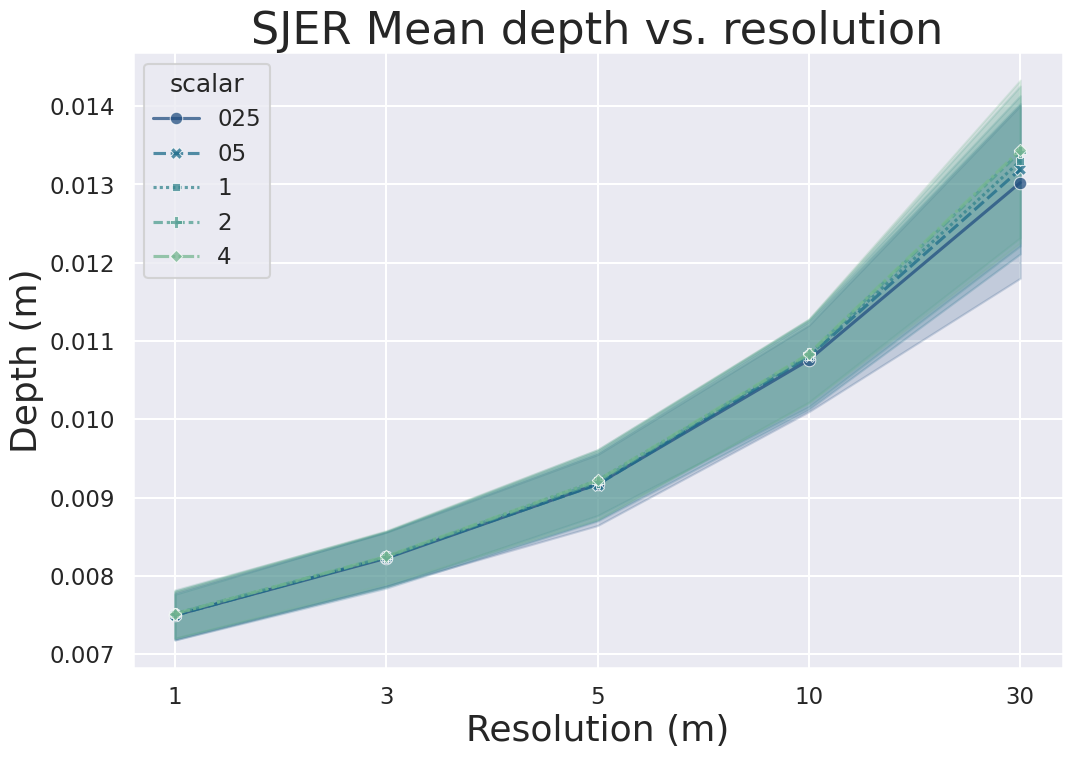

In [337]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="mean",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # ax=ax,
    markers=True,
    # kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)", fontsize=26)
plt.ylabel("Depth (m)", fontsize=26)
plt.title("SJER Mean depth vs. resolution", fontsize=32)
plt.savefig(f"../output/{site}/{mapset}/{site}_mean_depth_res_line_plot.png")
plt.show()

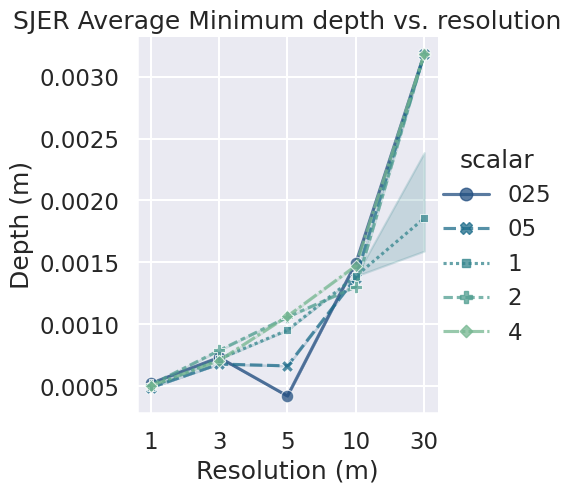

In [209]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="min",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # col="stat_type",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)")
plt.ylabel("Depth (m)")
plt.title("SJER Average Minimum depth vs. resolution")
plt.show()

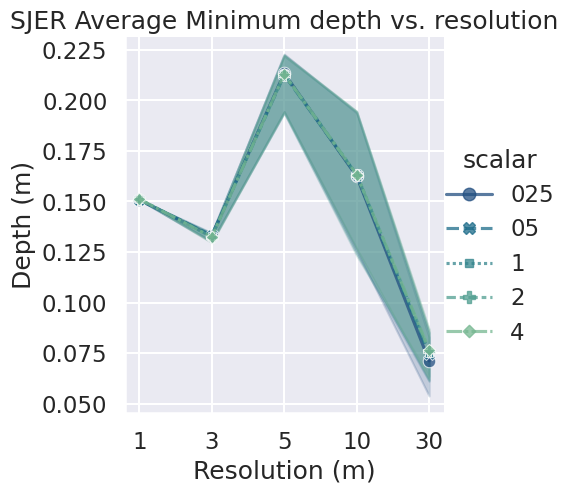

In [224]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="resolution",
    y="max",
    hue="scalar",
    palette="crest_r",
    alpha=0.75,
    # col="stat_type",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Resolution (m)")
plt.ylabel("Depth (m)")
plt.title("SJER Average Minimum depth vs. resolution")
plt.show()

In [328]:
# sns.jointplot(
#     data=result_vertical.query("stat_type == 'average'"),
#     x="mean", y="run_time", hue="resolution",
#     kind="kde"
# )

sns.displot(
    result_vertical.query("stat_type == 'average'"),
    x="stddev",
    x="run_time",
    hue="resolution", 
    kind="kde"
)


SyntaxError: keyword argument repeated: x (1147883723.py, line 10)

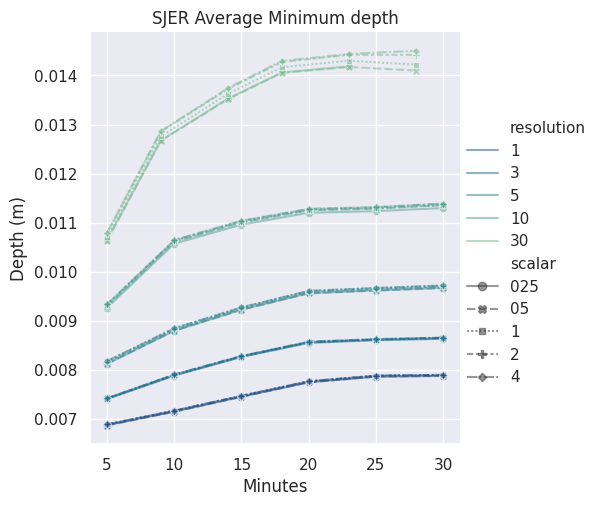

In [259]:
sns.set_context("notebook")
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="minute",
    y="mean",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    # size="run_time",
    # col="scalar",
    # row="resolution",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("SJER Average Minimum depth")
plt.show()

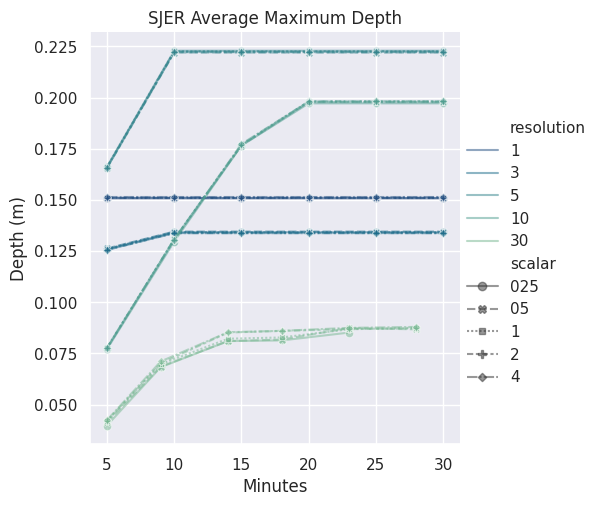

In [250]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="minute",
    y="max",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    # col="scalar",
    # row="resolution",
    # row="stat_type",
    # errorbar=('ci', 95),
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("SJER Average Maximum Depth")
plt.show()

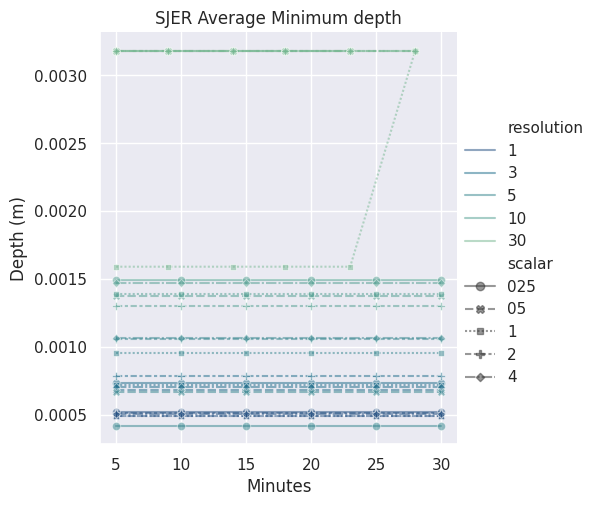

In [253]:
sns.relplot(
    data=result_vertical.query("stat_type == 'average'"),
    x="minute",
    y="min",
    hue="resolution",
    palette="crest_r",
    alpha=0.5,
    markers=True,
    kind="line",
    style="scalar"
)

plt.xlabel("Minutes")
plt.ylabel("Depth (m)")
plt.title("SJER Average Minimum depth")
plt.show()

<Axes: xlabel='mean', ylabel='Percent'>

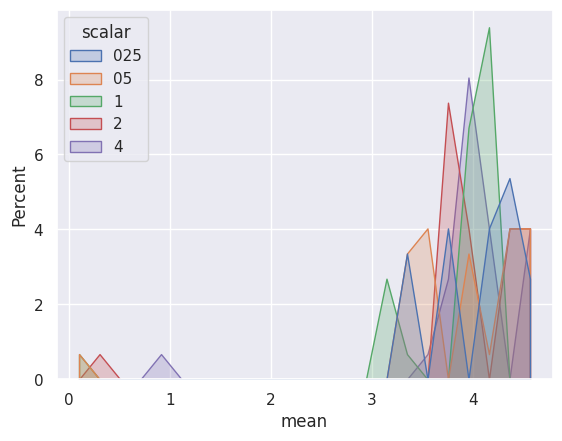

In [269]:
sns.histplot(
    data=result_vertical.query("stat_type == 'max_raster'"),
    x="mean",
    hue="scalar",
    element="poly",
    stat="percent"
)


In [ ]:
from PIL import Image
import imageio.v3 as iio
import os

def create_webp_animation(input_pngs, output_file, fps=60, loop=0):
    # Get a sorted list of PNG files in the input folder
    png_files = sorted(input_pngs)
    
    if not png_files:
        raise ValueError("No PNG files found in the specified folder.")
    
    # Read images
    images = [Image.open(png) for png in png_files]
    
    # Save as animated WebP
    iio.imwrite(
        output_file,
        [image for image in images],
        plugin="pillow",
        format="webp",
        fps=fps,
        loop=loop,
    )
    
    print(f"Animated WebP saved as {output_file}")

def create_static_map(site, res, scalar, step, method):
    PROJECT_MAPSET = "sensitivity_1"
    site = "SJER"
    output_image = f"../output/{site}/{PROJECT_MAPSET}/{site}_depth_{res}_{scalar}_s_{step}_{method}.png"
    dem_map = gj.Map(
        use_region=True,
        height=600,
        width=600,
        filename=output_image,
    )
    relief_map = f"elevation_{res}_relief"
    dem_map.d_shade(
        color=f"depth_{res}_{scalar}_s_{step}_{method}",
        shade=relief_map,
        brighten=30,
        overwrite=True,
    )
    dem_map.d_legend(
        title=f"Depth (m)",
        raster=f"depth_{res}_{scalar}_s_{step}_{method}",
        at=(10, 40, 82, 89),
        flags="bs",
        fontsize=14,
    )
    dem_map.d_barscale(at=(1, 12), flags="n")
    return output_image

def get_agg_simwe_time_steps(search_pattern):
    """Returns a list of time steps from the SIMWE output as """
    timestep_list = gs.read_command(
        "g.list",
        type="raster",
        pattern=search_pattern,
        separator="comma",
    ).strip()
    # print(timestep_list)
    black_list = ["min_raster", "max_raster"]
    time_steps = [
        str(t.split("_")[-3]) if any(black in t for black in black_list) else str(t.split("_")[-2]) for t in timestep_list.split(",")]
    # print(time_steps)
    def filter_subset(x):
        # print(x)
        if "_01m" not in x:
            return x

    time_steps_filtered = filter(lambda x: filter_subset(x), time_steps)
    return sorted(list(set(time_steps_filtered)))

# create_static_map(site=None, res=res, scalar=scalar_str, step="14", method="average")

In [309]:

model_spatial_res_params = ["1", "3", "5", "10", "30"]  # meters
model_particle_density_scalar_params = ["025", "05", "1", "2", "4"]
methods = "average,median,minimum,min_raster,maximum,max_raster,stddev,range"
dataframe_list = []

for res in model_spatial_res_params:
    gs.run_command("g.region", raster=f"elevation_{res}", flags="a")
    for scalar_str in model_particle_density_scalar_params:
        for method in methods.split(","):
            depth_average = f"depth_{res}_{scalar_str}_s_{method}"
            raster_depth_list = gs.parse_command(
                "t.rast.list",
                input=depth_average,
                format="json"
            )
            raster_depth_list= [m['name'] for m in raster_depth_list['data']]
            output_pngs = []
            time_steps = get_agg_simwe_time_steps(f"depth_{res}_{scalar_str}_s_*_{method}")
            # print(time_steps)
            for step in time_steps:
                output_png = create_static_map(site, res, scalar_str, step, method)
                output_pngs.append(output_png)
            # print(output_pngs)
            create_webp_animation(output_pngs, f"../output/{site}/{mapset}/{site}_depth_{res}_{scalar_str}_s_{method}.webp", fps=1, loop=0)
            # create_static_map(site=None, res=res, scalar=scalar_str, step=, method)

['05', '10', '15', '20', '25', '30']
['../output/SJER/sensitivity_1/SJER_depth_1_025_s_05_average.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_10_average.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_15_average.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_20_average.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_25_average.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_30_average.png']
Animated WebP saved as ../output/SJER/sensitivity_1/SJER_depth_1_025_s_average.webp
['05', '10', '15', '20', '25', '30']
['../output/SJER/sensitivity_1/SJER_depth_1_025_s_05_median.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_10_median.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_15_median.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_20_median.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_25_median.png', '../output/SJER/sensitivity_1/SJER_depth_1_025_s_30_median.png']
Animated WebP saved as ../output/SJER/sensitivity_1/SJ